In [1]:
import numpy as np
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.model_selection import learning_curve

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

import time

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

/Users/borjaeg/anaconda3/envs/uic_2018/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/borjaeg/anaconda3/envs/uic_2018/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
def bunch_to_dataframe(bunch):
  fnames = bunch.feature_names
  features = fnames.tolist() if isinstance(fnames, np.ndarray) else fnames
  features += ['target']
  return pd.DataFrame(data= np.c_[bunch['data'], bunch['target']],
                 columns=features)

In [3]:
bc = load_breast_cancer()
data = bunch_to_dataframe(bc)

### Exploración de los datos

In [4]:
data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0.0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0.0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0.0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0.0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0.0


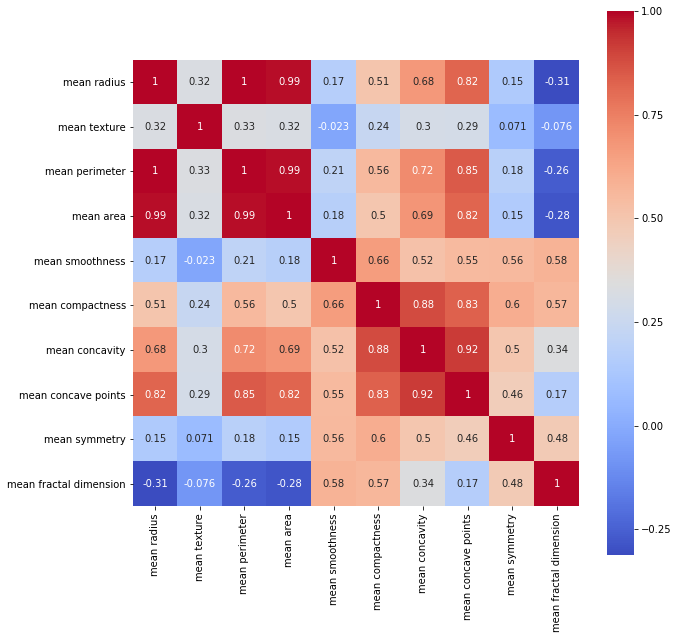

In [5]:
features_mean= list(data.columns[0:10])
plt.figure(figsize=(10,10))
sns.heatmap(data[features_mean].corr(), annot=True, square=True, cmap='coolwarm')
plt.show()

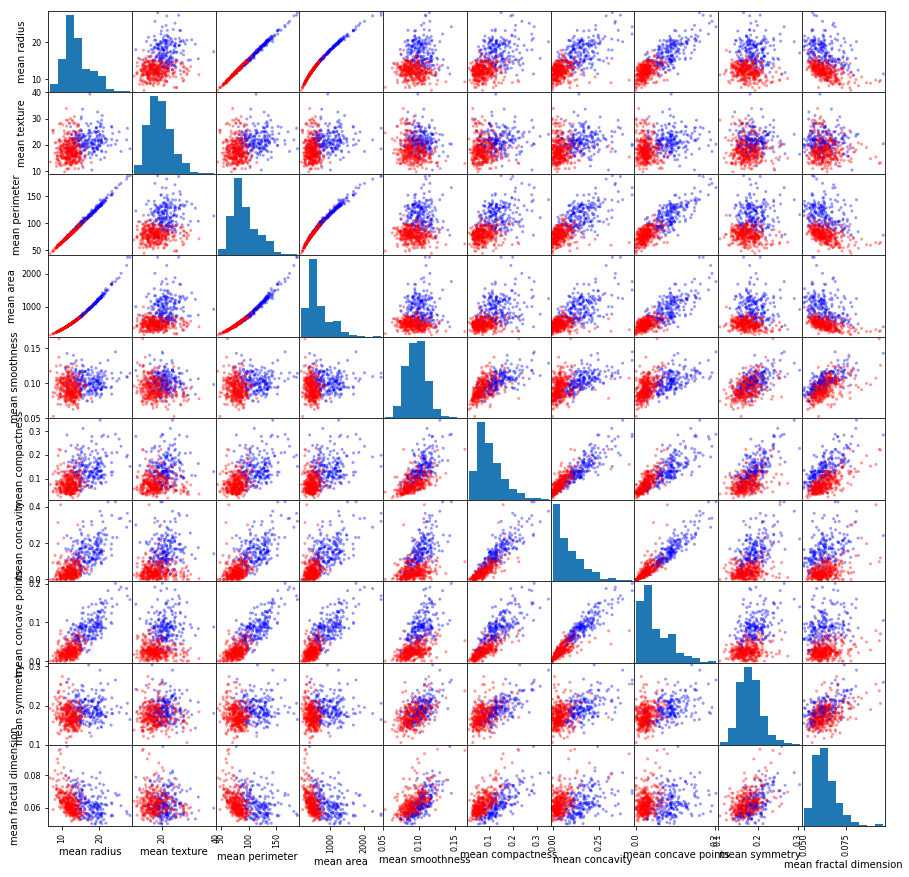

In [6]:
color_dic = {1.0:'red', 0.0:'blue'}
colors = data['target'].map(lambda x: color_dic.get(x))

sm = pd.scatter_matrix(data[features_mean], c=colors, alpha=0.4, figsize=((15,15)))

plt.show()

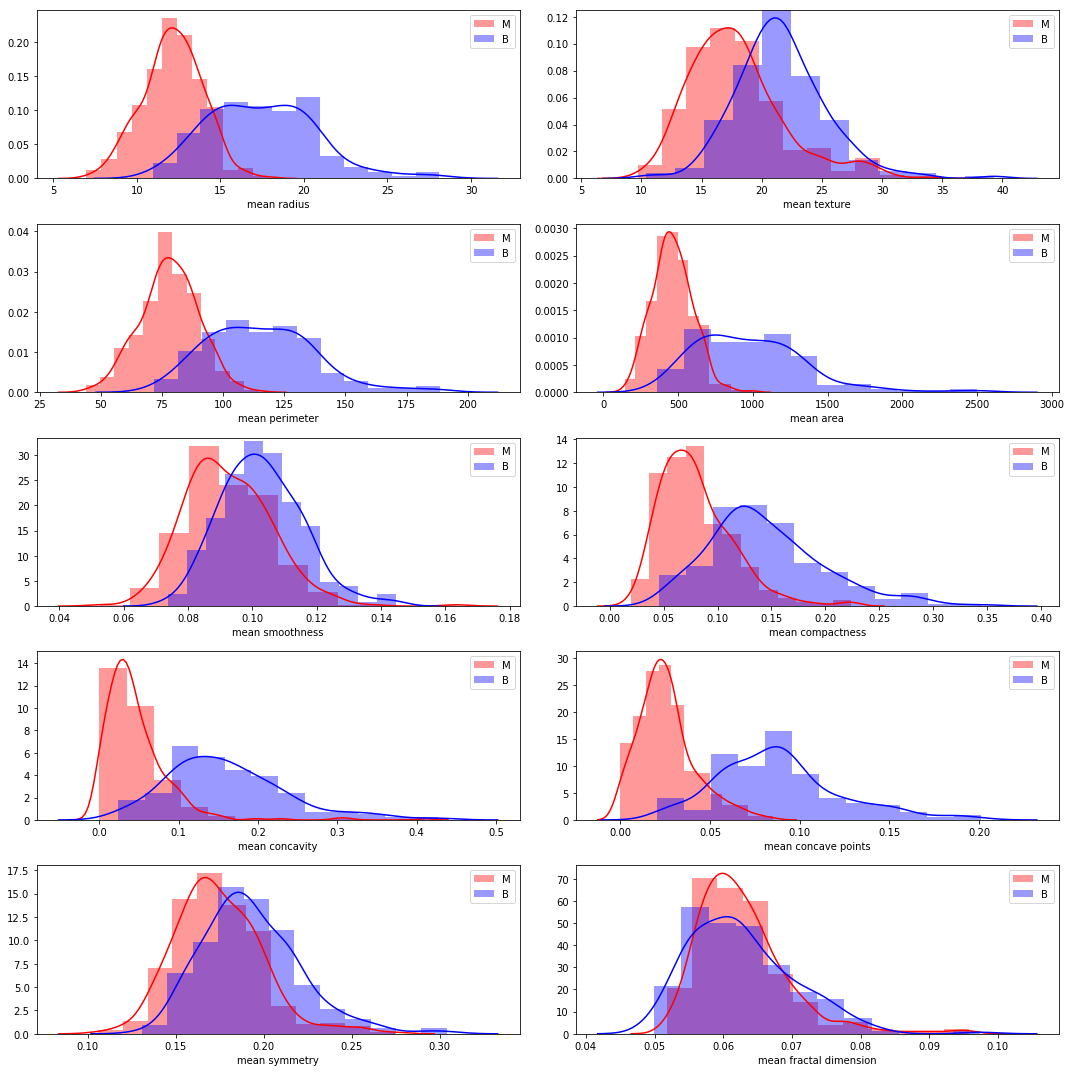

In [7]:
bins = 12
plt.figure(figsize=(15,15))
rows = int(len(features_mean)/2)
for i, feature in enumerate(features_mean):
    
    plt.subplot(rows, 2, i+1)
    
    sns.distplot(data[data['target']==1.0][feature], bins=bins, color='red', label='M');
    sns.distplot(data[data['target']==0.0][feature], bins=bins, color='blue', label='B');
    
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

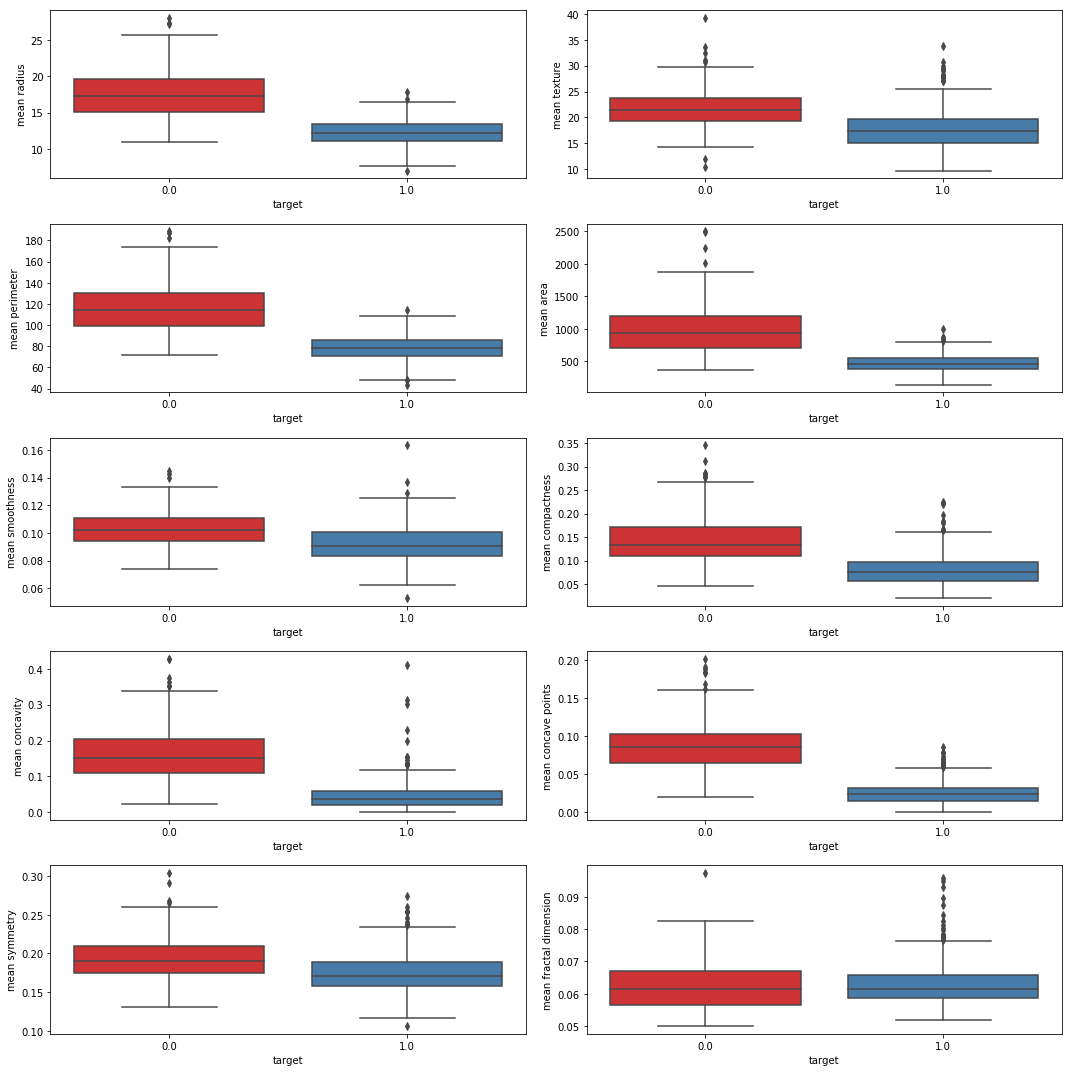

In [8]:
plt.figure(figsize=(15,15))
for i, feature in enumerate(features_mean):
    rows = int(len(features_mean)/2)
    
    plt.subplot(rows, 2, i+1)
    
    sns.boxplot(x='target', y=feature, data=data, palette="Set1")

plt.tight_layout()
plt.show()

### Machine Learning

In [9]:
X, y = load_breast_cancer(return_X_y=True)

In [10]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 3)):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim([0.8, 1.01])
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc='lower right')
    plt.show()

In [16]:
def plot_roc_curves(results, y_test):
    
    colors = ['r', 'g', 'b', 'y', 'm']
    
    plt.figure(figsize=(6, 6))
    for i, result in enumerate(results):
        name = result[0]
        predictions = result[1][:,1]
        fpr, tpr, _ =  roc_curve(y_test, predictions)
        auc_score = auc(fpr, tpr)
        label = name + ' AUC={0:0.2f}'.format(auc_score)
        plt.plot(fpr, tpr, color = colors[i], lw = 2, label = label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.ylim([0.6, 1.05])
        plt.xlim([0.0, 0.8])
        plt.legend(loc='lower right')
    plt.title('ROC curve')
    plt.show()

In [17]:
def plot_precision_recall_curves(results, y_test):
    
    colors = ['r', 'g', 'b', 'y', 'm']
    
    plt.figure(figsize=(6, 6))
    for i, result in enumerate(results):
        name = result[0]
        predictions = result[1][:,1]
        aps = average_precision_score(y_test, predictions)
        precision, recall, _ =  precision_recall_curve(y_test, predictions)
        label = name + ' AP={0:0.2f}'.format(aps)
        plt.plot(recall, precision, color = colors[i], lw = 2, label = label)
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.7, 1.05])
        plt.xlim([0.0, 1.05])
        plt.legend(loc='lower right')
    plt.title('Precision-Recall curve')
    plt.show()

In [18]:
def get_best_estimator(estimator, X_train, y_train):
    param_grid = {}
    param_grid["SVC"] = {'sel__k': [10, 20, 30], 
                         'clf__C': [1, 100], 
                         'clf__kernel': ['linear', 'rbf']}
    param_grid["NB"] = {'sel__k': [10, 20, 30],
                        'clf__priors':[[0.1, 0.9],[0.25, 0.75] ,[0.5, 0.5], [0.75, 0.25], [0.9, 0.1]]}
    param_grid["Log"] = {'sel__k': [10, 20, 30],
                         'clf__C': [1, 100, 1000]}
    param_grid["RF"] = {'sel__k': [10, 20, 30],
                        'clf__n_estimators': [10, 20, 50, 100]}
    param_grid["KNN"] = {'sel__k': [10, 20, 30],
                        'clf__n_neighbors': [3, 5, 10]}
    
    name = estimator[0]
    pipe = estimator[1]
    
    grid = GridSearchCV(pipe, cv=5, n_jobs=-1, refit = True,
                        param_grid=param_grid[name],
                        scoring = 'recall')
    
    start = time.time()
    grid.fit(X_train, y_train)
    end = time.time()
    print("Time: %.2f sec" % (end - start))
    
    print("Best Parameters")
    print(grid.best_params_)
    return grid.best_estimator_
    

In [19]:
def experiment():
    estimators = [
                   ("NB", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", GaussianNB())])),
                   ("Log", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", LogisticRegression())])),
                   ("RF", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", RandomForestClassifier())])),
                   ("KNN", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf", KNeighborsClassifier())])),
                    ("SVC", 
                       Pipeline([
                           ('sel', SelectKBest()),
                           ("clf",SVC(probability = True))]))
                  ]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,
                                                        stratify=y, shuffle=True)

    results = []

    for estimator in estimators:
        print(estimator[0])
        best_estimator = get_best_estimator(estimator, X_train, y_train)

        predictions = best_estimator.predict(X_test)
        print(classification_report(y_test, predictions))
        results.append((estimator[0], best_estimator.predict_proba(X_test)))
        scores = cross_val_score(best_estimator, X_test, y_test, cv=5, scoring='recall')
        print("Recall: %.2f (+/- %.2f)"% (np.mean(scores), np.std(scores)))
        plot_learning_curve(best_estimator, "Learning Curve " + estimator[0], 
                        X_train, y_train, ylim=None, cv=3,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        print("="*20)
    plot_precision_recall_curves(results, y_test)
    print("="*20)
    plot_roc_curves(results, y_test)

NB
Time: 0.59 sec
Best Parameters
{'clf__priors': [0.1, 0.9], 'sel__k': 20}
             precision    recall  f1-score   support

          0       0.98      0.86      0.92        70
          1       0.92      0.99      0.96       118

avg / total       0.94      0.94      0.94       188

Recall: 0.99 (+/- 0.02)


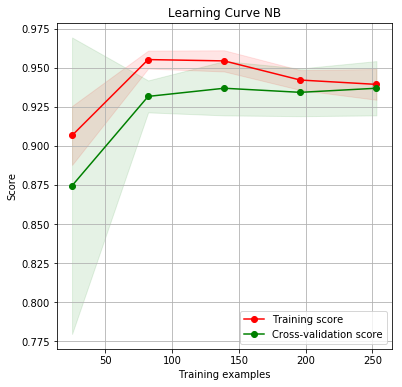

Log
Time: 0.35 sec
Best Parameters
{'clf__C': 1, 'sel__k': 10}
             precision    recall  f1-score   support

          0       0.96      0.93      0.94        70
          1       0.96      0.97      0.97       118

avg / total       0.96      0.96      0.96       188

Recall: 0.96 (+/- 0.04)


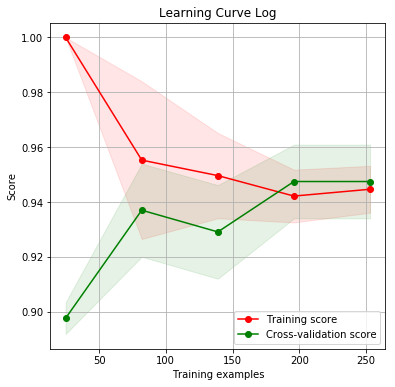

RF
Time: 2.21 sec
Best Parameters
{'clf__n_estimators': 20, 'sel__k': 20}
             precision    recall  f1-score   support

          0       0.97      0.97      0.97        70
          1       0.98      0.98      0.98       118

avg / total       0.98      0.98      0.98       188

Recall: 0.97 (+/- 0.03)


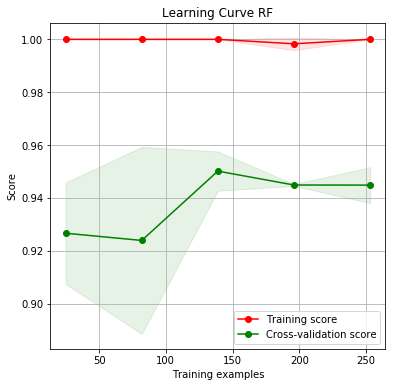

KNN
Time: 0.37 sec
Best Parameters
{'clf__n_neighbors': 3, 'sel__k': 10}
             precision    recall  f1-score   support

          0       0.90      0.91      0.91        70
          1       0.95      0.94      0.94       118

avg / total       0.93      0.93      0.93       188

Recall: 0.96 (+/- 0.03)


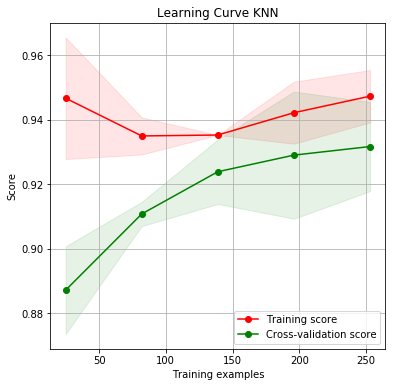

SVC
Time: 309.24 sec
Best Parameters
{'clf__C': 1, 'clf__kernel': 'rbf', 'sel__k': 10}
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        70
          1       0.63      1.00      0.77       118

avg / total       0.39      0.63      0.48       188

Recall: 1.00 (+/- 0.00)


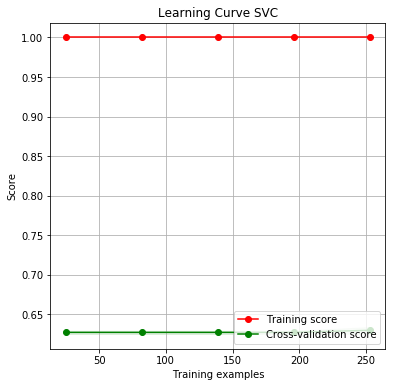

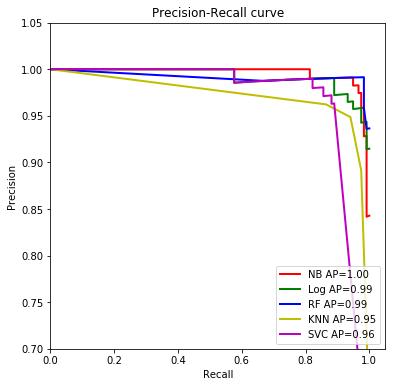

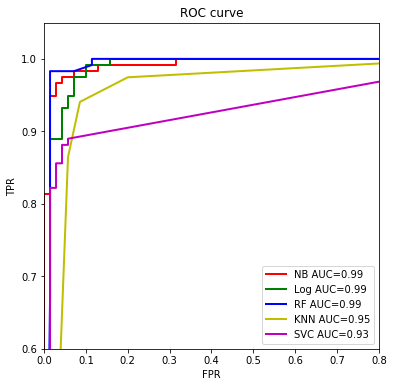

In [20]:
experiment()